## **전이 학습**

**전이학습(Transfer learning)**은 어떤 목적을 이루기 위해 학습된 모델을 다른 작업에 이용하는 것을 말함. 즉 모델의 지식을 다른 문제에 이용하는 것임.

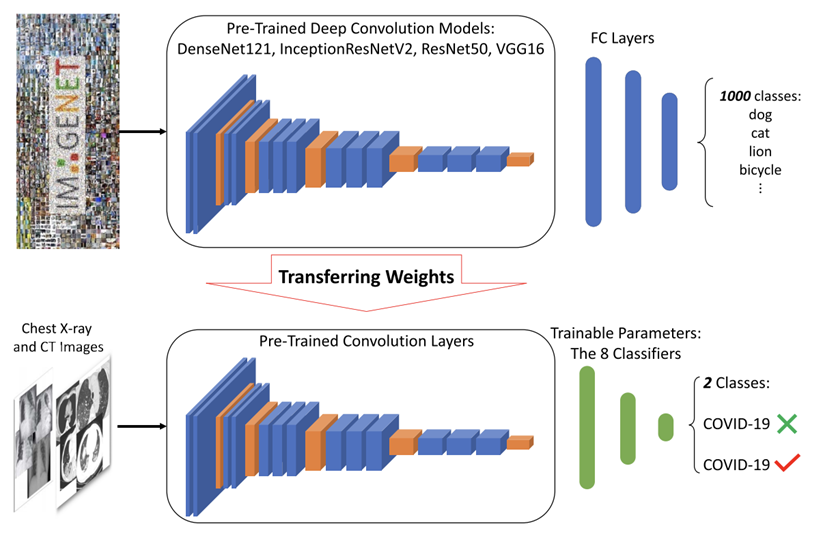

**전이 학습의 장점**
* **학습이 빠르게 수행될 수 있음**. 이미 입력되는 데이터에 대해 특징을 효율적으로 추출하기 때문에, 학습할 데이터에 대해 특징을 추출하기 위한 학습을 별도로 하지 않아도 되기 때문.

* **작은 데이터셋을 가지고 학습할 때 오버피팅 예방**. 적은 데이터로 특징을 추출하기 위한 학습을 하게 되면, 데이터 수에 비해 모델의 가중치 수가 많을 수 있어 미세한 특징까지 모두 학습할 수 있음. 전이 학습을 이용해 마지막 레이어만 학습하게 한다면, 학습할 가중치 수가 줄어 과한 학습이 이루어지지 않게 할 수 있음.

* 사전 학습과 미세 조정
전이 학습을 하기 위해서는 학습된 모델과 새로 학습할 데이터셋이 필요. 여기서 학습된 모델을 만드는 과정을 **사전 학습(pre-training)**이라고 함. **미세 조정(fine-tuning)**은 사전 학습된 모델을 새로운 문제에 적용하기 위해 일부 가중치를 조절하는 학습 과정을 말함.

### **치매 환자의 뇌인지 일반인의 뇌인지 예측하기**
**(1) 전이학습이 없는 학습**

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
import os
import natsort
from tqdm import tqdm
import cv2

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
train_datagen = ImageDataGenerator(rescale=1./255,          
                                  #horizontal_flip=True,     
                                  #width_shift_range=0.1,    
                                  #height_shift_range=0.1,
                                  #rotation_range=5,        
                                  #shear_range=0.7,        
                                  #zoom_range=1.2,          
                                  #vertical_flip=True,      
                                  #fill_mode='nearest'     
                                  )      

train_generator = train_datagen.flow_from_directory(
       '/content/drive/MyDrive/TL_DA/data/train',   
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       '/content/drive/MyDrive/TL_DA/data/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [131]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
#model.summary()

In [132]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_generator, epochs=5, validation_data=test_generator, validation_steps=10, callbacks=[early_stopping_callback])

Epoch 1/5
32/32 [==============================] - 102s 3s/step - loss: 0.6986 - accuracy: 0.5125 - val_loss: 0.6898 - val_accuracy: 0.4600
Epoch 2/5
32/32 [==============================] - 20s 647ms/step - loss: 0.6781 - accuracy: 0.6187 - val_loss: 0.6897 - val_accuracy: 0.4000
Epoch 3/5
32/32 [==============================] - 12s 396ms/step - loss: 0.6567 - accuracy: 0.5875 - val_loss: 0.6501 - val_accuracy: 0.6000
Epoch 4/5
32/32 [==============================] - 11s 363ms/step - loss: 0.5776 - accuracy: 0.7625 - val_loss: 0.5697 - val_accuracy: 0.7400
Epoch 5/5
32/32 [==============================] - 8s 255ms/step - loss: 0.5058 - accuracy: 0.8062 - val_loss: 0.3800 - val_accuracy: 0.9400


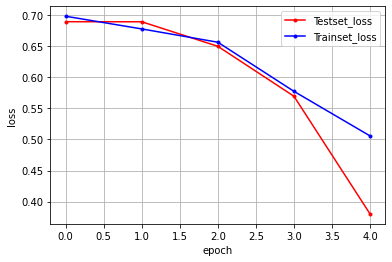

In [133]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**(2) 전이 학습**

In [134]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [135]:
train_datagen = ImageDataGenerator(rescale=1./255,         
                                  # horizontal_flip=True,    
                                  # width_shift_range=0.1,    
                                  # height_shift_range=0.1,
                                  # rotation_range=5,      
                                  # shear_range=0.7,
                                  # zoom_range=1.2,
                                  # vertical_flip=True,
                                  # fill_mode='nearest'
                                  )      

train_generator = train_datagen.flow_from_directory(
       '/content/drive/MyDrive/TL_DA/data/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       '/content/drive/MyDrive/TL_DA/data/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


https://keras.io/api/applications/

In [ ]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

In [ ]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

In [138]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

history = finetune_model.fit(
       train_generator,
       epochs=5,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/5
32/32 [==============================] - 51s 2s/step - loss: 0.6928 - accuracy: 0.5625 - val_loss: 0.5380 - val_accuracy: 0.8600
Epoch 2/5
32/32 [==============================] - 48s 1s/step - loss: 0.4994 - accuracy: 0.7437 - val_loss: 0.4287 - val_accuracy: 0.9400
Epoch 3/5
32/32 [==============================] - 48s 2s/step - loss: 0.4481 - accuracy: 0.8125 - val_loss: 0.3278 - val_accuracy: 0.9400
Epoch 4/5
32/32 [==============================] - 48s 2s/step - loss: 0.3460 - accuracy: 0.9000 - val_loss: 0.3180 - val_accuracy: 0.9200
Epoch 5/5
32/32 [==============================] - 47s 1s/step - loss: 0.2977 - accuracy: 0.9187 - val_loss: 0.3213 - val_accuracy: 0.8800


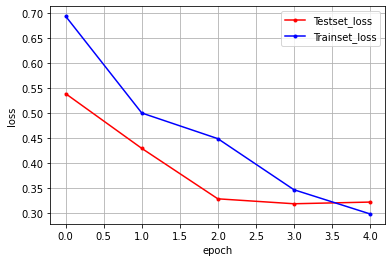

In [139]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()